
# 00 — Evaluación de Modelos LSTM (Polyrhythmia) con Gráficas

Este notebook evalúa **cada modelo por separado** con una **estructura fija** y añade **gráficas explicativas**.

- Detección de modelos en `models/final/*.h5` y `*.keras`.
- Carga del *dataset* (por defecto `data/processed/dataset_3/...`).
- Métricas por modelo: **Loss**, **Accuracy**, **Perplexity**, y métricas musicales (**Densidad**, **Síncopa**, **Co-ocurrencias**, **F1 por instrumento**).
- **Gráficas** (una por figura, sin estilos especiales) para comparar resultados.
- Reporte JSON y tabla resumen.


In [46]:

import os, json, math, glob, pathlib as P
import numpy as np
import tensorflow as tf
from typing import Dict, Any
import time

# ====== CONFIGURACIÓN ======
PROJECT_ROOT = P.Path.cwd().parents[1]

DATASET = {
    "train": PROJECT_ROOT / "data/processed/dataset_3/train.npz",
    "val":   PROJECT_ROOT / "data/processed/dataset_3/validation.npz",
    "test":  PROJECT_ROOT / "data/processed/dataset_3/test.npz",
    "vocab_topN": PROJECT_ROOT / "data/processed/dataset_3/vocab_topN.json",
    "vocab":      PROJECT_ROOT / "data/processed/dataset_3/vocab.json",
}

MODELS_DIR = PROJECT_ROOT / "models/final"
MODELS = sorted(list(MODELS_DIR.glob("*.keras")) + list(MODELS_DIR.glob("*.h5")))

OUT_DIR = PROJECT_ROOT / "experiments" / (time.strftime("%Y-%m-%d") + "_eval")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("Encontrados modelos:", [m.name for m in MODELS])
print("OUT_DIR:", OUT_DIR)


PROJECT_ROOT: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm
Encontrados modelos: ['best.h5', 'best_2.h5', 'best_2_ls010_do035_vocab128.h5', 'best_3.h5']
OUT_DIR: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval


In [47]:

def load_npz(path):
    d = np.load(path, allow_pickle=True)
    X = d["X_tokens"] if "X_tokens" in d.files else d["X"]
    Y = d["Y_tokens"] if "Y_tokens" in d.files else d["Y"]
    G = d["X_style"] if "X_style" in d.files else None
    return X, Y, G

def make_positional(N, T):
    return np.tile(np.arange(1, T+1, dtype=np.int32), (N, 1))

def ensure_style(G, N, S=6):
    if G is None:
        return np.zeros((N, S), dtype=np.float32)
    return G.astype(np.float32)

def load_vocab_map():
    vocab_path = DATASET["vocab_topN"] if DATASET["vocab_topN"].exists() else DATASET["vocab"]
    if not vocab_path.exists():
        return None
    with open(vocab_path, "r", encoding="utf-8") as f:
        vocab = json.load(f)
    id2bitmask = None
    if isinstance(vocab, dict):
        key = None
        for k in ["id2bitmask", "id_to_bitmask", "id2bit"]:
            if k in vocab:
                key = k; break
        if key is not None:
            raw = vocab[key]
            id2bitmask = {int(k): np.array(v, dtype=np.int32) for k, v in raw.items()}
    return id2bitmask


In [48]:

from sklearn.metrics import f1_score

def _to_bitvector(bm, I=9):
    """
    Convierte bm (lista, ndarray, o escalar/entero codificado en bits) a np.array shape (I,).
    - Si es escalar/int: decodifica a I bits (LSB primero).
    - Si es array/lista: flattéalo y ajusta longitud a I (recorta o rellena con ceros).
    """
    if bm is None:
        return np.zeros((I,), dtype=np.int32)

    # Si es np.ndarray 0-D (escalar), conviértelo a Python escalar
    if isinstance(bm, np.ndarray) and bm.ndim == 0:
        bm = bm.item()

    # Caso escalar/entero -> decodificar bits
    if isinstance(bm, (int, np.integer)):
        v = np.zeros((I,), dtype=np.int32)
        x = int(bm)
        for k in range(I):
            v[k] = (x >> k) & 1
        return v

    # Caso lista/tupla/ndarray 1-D o más
    arr = np.array(bm).astype(np.int32).ravel()
    if arr.size >= I:
        return arr[:I]
    else:
        out = np.zeros((I,), dtype=np.int32)
        out[:arr.size] = arr
        return out


def tokens_to_multihot(seq_ids: np.ndarray, id2bitmask: dict, I: int = 9) -> np.ndarray:
    """
    seq_ids: (T,) ids de vocab
    id2bitmask: dict id-> (lista/ndarray de bits, o entero codificado en bits)
    Devuelve M: (T, I) con 0/1 por instrumento.
    """
    T = int(seq_ids.shape[0])
    M = np.zeros((T, I), dtype=np.int32)
    if id2bitmask is None:
        return M  # sin vocab → zeros

    for t in range(T):
        bm = id2bitmask.get(int(seq_ids[t]), None)
        M[t] = _to_bitvector(bm, I=I)
    return M


def density(M: np.ndarray) -> float:
    return float((M.sum(axis=1) > 0).mean())

def syncopation(M: np.ndarray) -> float:
    on  = M[::2].sum() / max(1, M[::2].size)
    off = M[1::2].sum() / max(1, M[1::2].size)
    return float(off / (on + 1e-6))

def cooccurrence(M: np.ndarray) -> np.ndarray:
    T = M.shape[0]
    return (M.T @ M) / max(1, T)

def f1_per_instrument(M_true: np.ndarray, M_pred: np.ndarray) -> np.ndarray:
    I = M_true.shape[1]
    f1s = []
    for i in range(I):
        f1s.append(f1_score(M_true[:, i].ravel(), M_pred[:, i].ravel(), zero_division=0))
    return np.array(f1s, dtype=np.float32)

def sparse_ce_with_smoothing(y_true_int: np.ndarray, y_pred: np.ndarray, eps: float = 0.1) -> float:
    B, T, V = y_pred.shape
    y_oh = np.eye(V, dtype=np.float32)[y_true_int]
    y_oh = y_oh * (1.0 - eps) + (eps / float(V))
    p = np.clip(y_pred, 1e-7, 1.0)
    ce = -np.sum(y_oh * np.log(p), axis=-1)
    return float(np.mean(ce))


In [49]:
def infer_num_instruments(id2bitmask, default_I=9):
    if not id2bitmask:
        return default_I
    for k, bm in id2bitmask.items():
        # normaliza a vector y devuelve su longitud
        v = _to_bitvector(bm, I=default_I)
        return v.shape[0]
    return default_I

I_detected = infer_num_instruments(id2bit)
print("I (número de instrumentos) detectado:", I_detected)


I (número de instrumentos) detectado: 9


In [50]:

def safe_load_model(path):
    try:
        return tf.keras.models.load_model(path, compile=False)
    except Exception as e:
        print(f"[WARN] Carga directa falló en {path.name}: {e}\nReintentando con custom_objects...")
        class SparseCELS(tf.keras.losses.Loss):
            def __init__(self, ls=0.1, name='SparseCELS'): 
                super().__init__(name=name); self.ls = ls
            def call(self, y_true, y_pred):
                V = tf.shape(y_pred)[-1]
                y_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=V)
                y_oh = y_oh * (1.0 - self.ls) + (self.ls / tf.cast(V, tf.float32))
                p = tf.clip_by_value(y_pred, 1e-7, 1.0)
                ce = -tf.reduce_sum(y_oh * tf.math.log(p), axis=-1)
                return tf.reduce_mean(ce)
        return tf.keras.models.load_model(path, compile=False, custom_objects={"SparseCELS": SparseCELS})


In [51]:
def get_model_vocab_size(model):
    # intenta por shape de salida
    try:
        V = int(model.output_shape[-1])
        if V > 0:
            return V
    except Exception:
        pass
    # fallback: busca última Dense con units
    for layer in reversed(model.layers):
        cfg = getattr(layer, 'get_config', lambda: {})()
        if cfg and 'units' in cfg:
            return int(cfg['units'])
    raise ValueError("No pude inferir el vocab_size (V) del modelo.")


In [52]:
def prepare_for_model(model, X_slice, pos_slice, Z_slice):
    V = get_model_vocab_size(model)
    # cap al rango [0, V-1]
    Xc = np.minimum(X_slice, V-1).astype(np.int32, copy=False)
    Yc = None  # lo cierras en evaluate_teacher_forced
    posc = pos_slice.astype(np.int32, copy=False)
    Zc = None if Z_slice is None else Z_slice.astype(np.float32, copy=False)
    return V, Xc, posc, Zc


In [53]:

def evaluate_teacher_forced(model, X, Y, Z, batch_size=256, label_smoothing=0.1):
    N, T = X.shape
    pos = np.tile(np.arange(1, T+1, dtype=np.int32), (N, 1))
    preds_ids = np.zeros_like(Y)

    total_loss = 0.0
    total_acc  = 0.0
    n_batches  = 0

    for i in range(0, N, batch_size):
        j = min(i + batch_size, N)

        # Prepara entradas según V del modelo
        V_model, Xc, posc, Zc = prepare_for_model(model, X[i:j], pos[i:j], Z[i:j])

        # Predicción
        y_pred = predict_batch(model, Xc, posc, Zc)  # (b,T,V)
        y_true = Y[i:j]
        # Capear ground-truth a V del modelo para que el one-hot no reviente
        y_true_cap = np.minimum(y_true, V_model-1)

        y_hat  = np.argmax(y_pred, axis=-1)         # (b,T)
        acc = (y_hat == y_true_cap).mean()
        loss = sparse_ce_with_smoothing(y_true_cap, y_pred, eps=label_smoothing)

        total_loss += loss
        total_acc  += acc
        n_batches  += 1
        preds_ids[i:j] = y_hat

    avg_loss = total_loss / max(1, n_batches)
    avg_acc  = total_acc  / max(1, n_batches)
    ppx = math.exp(avg_loss)
    return {"loss": avg_loss, "accuracy": avg_acc, "perplexity": ppx}, preds_ids


In [54]:
def infer_model_signature(model, T_expected: int, S_expected: int):
    """
    Inspecciona entradas del modelo y devuelve un dict con el mapeo de roles:
      - tokens: índice de entrada para tokens (shape rank 2 con last_dim=T or <=T)
      - pos:    índice de entrada para pos (shape rank 2 con last_dim=T)
      - style:  índice de entrada para style (shape rank 2 con last_dim=S)
    Soporta 1, 2 o 3 entradas.
    """
    sig = {"tokens": None, "pos": None, "style": None}
    inputs = model.inputs  # list of KerasTensors
    n = len(inputs)

    # util para leer nombre y última dim
    def last_dim(t):
        try:
            return int(t.shape[-1])
        except Exception:
            return None

    def in_name(t):
        try:
            return t.name.lower()
        except Exception:
            return ""

    # Paso 1: intenta por nombre
    for idx, t in enumerate(inputs):
        name = in_name(t)
        if "token" in name:
            sig["tokens"] = idx
        elif "pos" in name or "position" in name:
            sig["pos"] = idx
        elif "style" in name or "genre" in name or "emb" in name:
            sig["style"] = idx

    # Paso 2: completa por forma si queda algo sin asignar
    for idx, t in enumerate(inputs):
        if idx in sig.values():
            continue
        ld = last_dim(t)

        # candidato de style si coincide S_expected
        if sig["style"] is None and ld is not None and S_expected is not None and ld == S_expected:
            sig["style"] = idx
            continue

        # candidato de pos si coincide T_expected
        if sig["pos"] is None and ld is not None and T_expected is not None and ld == T_expected:
            sig["pos"] = idx
            continue

        # tokens: si nada más aplica
        if sig["tokens"] is None:
            sig["tokens"] = idx

    # sanity: si solo hay 1 entrada, debe ser tokens
    if n == 1:
        sig["tokens"] = 0
        sig["pos"] = None
        sig["style"] = None

    # si hay 2 entradas y una coincide con S_expected, asume (tokens, style);
    # si una coincide con T_expected, asume (tokens, pos)
    if n == 2:
        # fuerza tokens en la que no encaja ni con T ni con S, si existe
        for idx, t in enumerate(inputs):
            if idx not in sig.values():
                sig["tokens"] = idx

    return sig

def predict_batch(model, X, pos, Z):
    """
    Predice respetando la firma del modelo.
    - X, pos int32; Z float32
    Retorna y_pred (B,T,V).
    """
    # Asumimos que X,pos,Z ya vienen con dtypes correctos y X ya capado
    sig = infer_model_signature(model, T_expected=X.shape[1], S_expected=(None if Z is None else Z.shape[1]))

    idx2tensor = {}
    if sig["tokens"] is not None:
        idx2tensor[sig["tokens"]] = X
    if sig["pos"] is not None:
        idx2tensor[sig["pos"]] = pos
    if sig["style"] is not None:
        if Z is None:
            Z = np.zeros((X.shape[0], 6), dtype=np.float32)
        idx2tensor[sig["style"]] = Z

    feeds = [idx2tensor[k] for k in sorted(idx2tensor.keys())]
    if len(feeds) == 0 or sig["tokens"] is None:
        raise ValueError("No se pudo identificar la entrada de 'tokens' para este modelo.")

    return model(feeds, training=False).numpy()




In [55]:

# Carga del split de validación por defecto
X_val, Y_val, G_val = load_npz(DATASET["val"])
S = G_val.shape[1] if G_val is not None else 6
Z_val = ensure_style(G_val, len(X_val), S)
id2bit = load_vocab_map()
print("Val shape:", X_val.shape, Y_val.shape, Z_val.shape)

reports = []
pred_cache = {}

for mpath in MODELS:
    print(f"\n==== Evaluando: {mpath.name} ====")
    model = safe_load_model(mpath)

    tf_report, yhat_val = evaluate_teacher_forced(model, X_val, Y_val, Z_val, batch_size=256, label_smoothing=0.1)
    print("teacher:", tf_report)

    # Métricas musicales (ejemplo sobre el PRIMER compás del set para consistencia)
    mus = {}
    if id2bit is not None and len(X_val) > 0:
        y_true_ids = Y_val[0]
        y_pred_ids = yhat_val[0]
        from numpy import ndarray
        M_true = tokens_to_multihot(y_true_ids, id2bit, I=9)
        M_pred = tokens_to_multihot(y_pred_ids, id2bit, I=9)
        mus = {
            "density": density(M_pred),
            "syncopation": syncopation(M_pred),
            "cooccurrence": cooccurrence(M_pred).tolist(),
            "f1_per_instrument": f1_per_instrument(M_true, M_pred).tolist()
        }

    report = {
        "model_path": str(mpath),
        "split": "val",
        "teacher_forced": tf_report,
        "musical_metrics_example_first_bar": mus
    }
    reports.append(report)
    pred_cache[mpath.name] = {"yhat_val": yhat_val[:32]}  # guarda algunas predicciones para inspección

OUT_JSON = OUT_DIR / "model_eval_reports.json"
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(reports, f, indent=2)
print("\nGuardado:", OUT_JSON)

try:
    import pandas as pd
    rows = []
    for r in reports:
        rows.append({
            "model": P.Path(r["model_path"]).name,
            "loss": r["teacher_forced"]["loss"],
            "accuracy": r["teacher_forced"]["accuracy"],
            "perplexity": r["teacher_forced"]["perplexity"],
        })
    df = pd.DataFrame(rows).sort_values(by="loss")
    display(df)
except Exception as e:
    print("Pandas no disponible:", e)


Val shape: (2298, 16) (2298, 16) (2298, 6)

==== Evaluando: best.h5 ====
teacher: {'loss': 2.664936754438612, 'accuracy': 0.5408565538194444, 'perplexity': 14.367040865697021}

==== Evaluando: best_2.h5 ====
teacher: {'loss': 2.1992589235305786, 'accuracy': 0.5529772135416667, 'perplexity': 9.018327751924542}

==== Evaluando: best_2_ls010_do035_vocab128.h5 ====
teacher: {'loss': 2.1148535278108387, 'accuracy': 0.5550407986111111, 'perplexity': 8.28837166126329}

==== Evaluando: best_3.h5 ====
teacher: {'loss': 4.01797808541192, 'accuracy': 0.08282682291666667, 'perplexity': 55.58859672857509}

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\model_eval_reports.json


,model,loss,accuracy,perplexity
2,best_2_ls010_do035_vocab128.h5,2.114854,0.555041,8.288372
1,best_2.h5,2.199259,0.552977,9.018328
0,best.h5,2.664937,0.540857,14.367041
3,best_3.h5,4.017978,0.082827,55.588597



## Visualizaciones

A continuación se generan **gráficas individuales** (una por figura) para facilitar la interpretación.
Las figuras se guardan además en `experiments/<fecha>_eval/figures/`.

**Qué se visualiza:**
1. **Barras de Accuracy por modelo** — mayor es mejor.
2. **Barras de Perplexity por modelo** — menor es mejor (perplejidad ≈ e^(loss)).
3. **Histograma de Densidad (ejemplo)** — distribución de pasos con golpe (>0) sobre un compás generado *teacher-forced*.
4. **Histograma de Síncopa (ejemplo)** — razón *off-beat/on-beat*; >1 indica más peso en contratiempos.
5. **Mapa de Co-ocurrencias (ejemplo)** — matriz (9×9) con co-activación media por instrumento.
6. **Barras F1 por instrumento (ejemplo)** — equilibrio precisión/recuerdo por instrumento.

> Nota: los gráficos 'de ejemplo' se calculan sobre el **primer compás del split de validación** con las predicciones teacher-forced para consistencia.


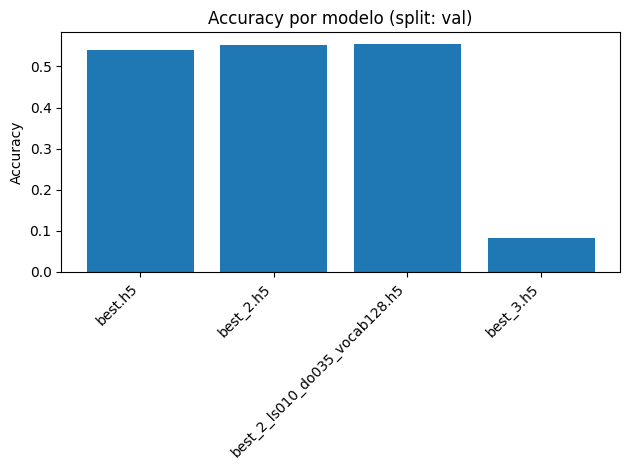

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\accuracy_por_modelo.png


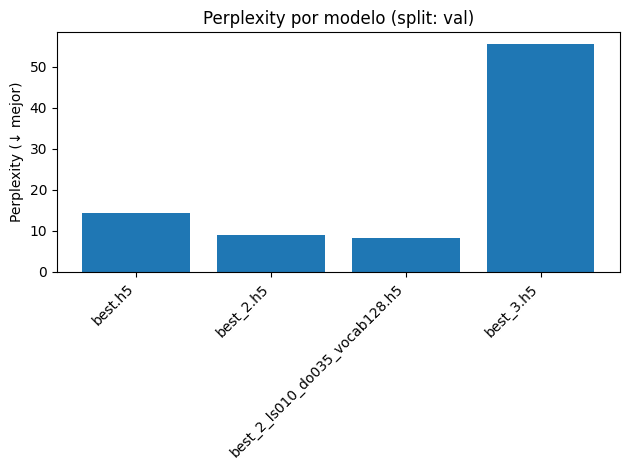

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\perplexity_por_modelo.png


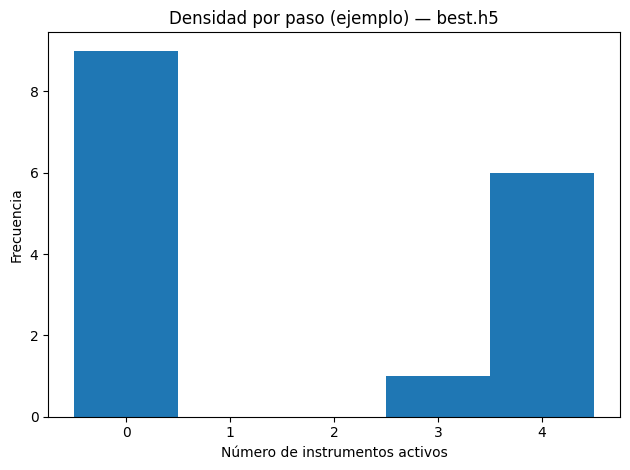

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\density_hist_best.h5.png


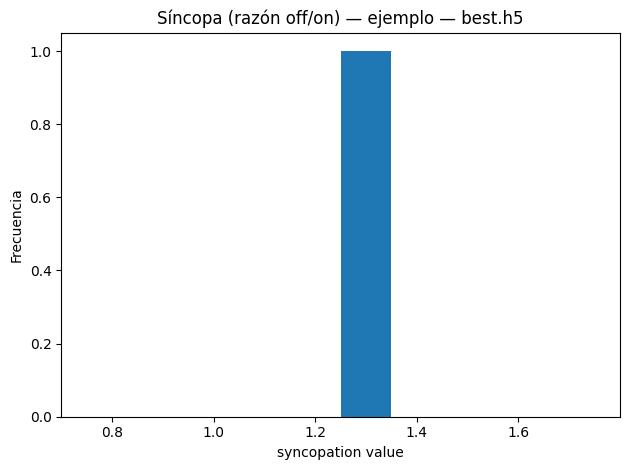

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\syncopation_hist_best.h5.png


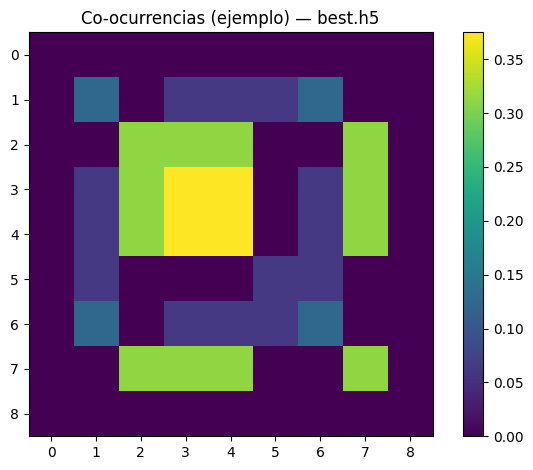

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\cooccurrence_map_best.h5.png


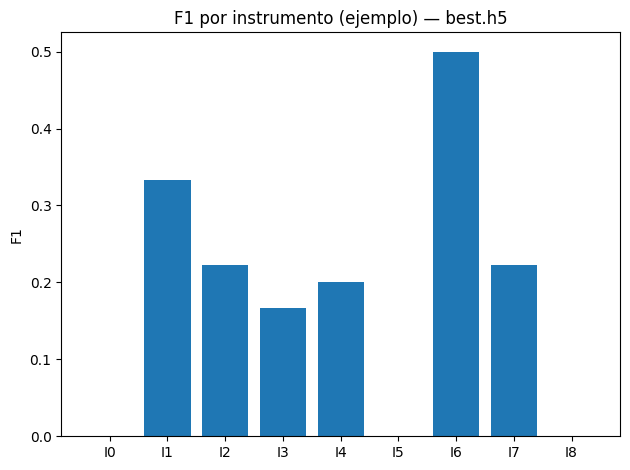

Guardado: c:\Users\Djcho\Documents\Repositories\Polyrhythmia\model_lstm\experiments\2025-10-12_eval\figures\f1_per_instrument_best.h5.png


In [56]:

import matplotlib.pyplot as plt

FIG_DIR = OUT_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Tabla de resumen para gráficas
try:
    import pandas as pd
    rows = []
    for r in reports:
        rows.append({
            "model": P.Path(r["model_path"]).name,
            "loss": r["teacher_forced"]["loss"],
            "accuracy": r["teacher_forced"]["accuracy"],
            "perplexity": r["teacher_forced"]["perplexity"],
        })
    df_plot = pd.DataFrame(rows)
except Exception as e:
    df_plot = None
    print("Pandas no disponible:", e)

# 1) Accuracy bar
if df_plot is not None and len(df_plot) > 0:
    plt.figure()
    plt.bar(df_plot["model"], df_plot["accuracy"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Accuracy por modelo (split: val)")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    acc_path = FIG_DIR / "accuracy_por_modelo.png"
    plt.savefig(acc_path, dpi=150)
    plt.show()
    print("Guardado:", acc_path)

# 2) Perplexity bar
if df_plot is not None and len(df_plot) > 0:
    plt.figure()
    plt.bar(df_plot["model"], df_plot["perplexity"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Perplexity por modelo (split: val)")
    plt.ylabel("Perplexity (↓ mejor)")
    plt.tight_layout()
    ppx_path = FIG_DIR / "perplexity_por_modelo.png"
    plt.savefig(ppx_path, dpi=150)
    plt.show()
    print("Guardado:", ppx_path)

# 3-6) Ejemplo musical: toma el primer modelo (si hay)
if len(reports) > 0 and id2bit is not None and len(X_val) > 0:
    r0 = reports[0]
    model_name = P.Path(r0["model_path"]).name
    yhat_val = pred_cache[model_name]["yhat_val"][0]  # (T,) primeras predicciones
    y_true = load_npz(DATASET["val"])[1][0]          # (T,)
    M_true = tokens_to_multihot(y_true, id2bit, I=9)
    M_pred = tokens_to_multihot(yhat_val, id2bit, I=9)

    # 3) Histograma densidad (por paso: nº instrumentos activos)
    plt.figure()
    dens_counts = M_pred.sum(axis=1)  # (T,)
    plt.hist(dens_counts, bins=np.arange(dens_counts.max()+2)-0.5)
    plt.title(f"Densidad por paso (ejemplo) — {model_name}")
    plt.xlabel("Número de instrumentos activos")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    dfig = FIG_DIR / f"density_hist_{model_name}.png"
    plt.savefig(dfig, dpi=150)
    plt.show()
    print("Guardado:", dfig)

    # 4) Histograma de síncopa (usa la métrica compacta)
    plt.figure()
    syn_value = syncopation(M_pred)
    plt.hist([syn_value], bins=10)
    plt.title(f"Síncopa (razón off/on) — ejemplo — {model_name}")
    plt.xlabel("syncopation value")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    sfig = FIG_DIR / f"syncopation_hist_{model_name}.png"
    plt.savefig(sfig, dpi=150)
    plt.show()
    print("Guardado:", sfig)

    # 5) Mapa de co-ocurrencias (9x9)
    plt.figure()
    C = cooccurrence(M_pred)
    plt.imshow(C)
    plt.title(f"Co-ocurrencias (ejemplo) — {model_name}")
    plt.colorbar()
    plt.tight_layout()
    cfig = FIG_DIR / f"cooccurrence_map_{model_name}.png"
    plt.savefig(cfig, dpi=150)
    plt.show()
    print("Guardado:", cfig)

    # 6) F1 por instrumento
    plt.figure()
    f1s = f1_per_instrument(M_true, M_pred)
    plt.bar(np.arange(len(f1s)), f1s)
    plt.xticks(np.arange(9), [f"I{i}" for i in range(9)])
    plt.title(f"F1 por instrumento (ejemplo) — {model_name}")
    plt.ylabel("F1")
    plt.tight_layout()
    f1fig = FIG_DIR / f"f1_per_instrument_{model_name}.png"
    plt.savefig(f1fig, dpi=150)
    plt.show()
    print("Guardado:", f1fig)
else:
    print("No hay modelos o vocab para gráficas musicales de ejemplo.")
